In [ ]:
# --------------------------- Importing Necessary Libraries --------------------------- #

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
import os
import time
import wandb  # For experiment tracking
import pandas as pd
from typing import Union, Optional, Iterable
from sklearn.preprocessing import StandardScaler

# --------------------------- Reproducibility and Device Configuration --------------------------- #

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------- BiddingSimulation Environment Definition --------------------------- #

# ==========================
# Helper Functions (Replacing 'rust' Module)
# ==========================

def sum_array_bool(arr: np.ndarray) -> int:
    """Sum a boolean array as integers."""
    return int(np.sum(arr))

def sum_array(arr: np.ndarray) -> float:
    """Sum a numpy array."""
    return float(np.sum(arr))

def sum_list(lst: list) -> float:
    """Sum a list of numbers."""
    return float(np.sum(lst))

def list_to_zeros(lst: list) -> np.ndarray:
    """Convert a list to a numpy array of zeros with the same length."""
    return np.zeros(len(lst))

def binomial_impressions(num_auctions: int, impression_rate: float) -> int:
    """Simulate the number of impressions using a binomial distribution."""
    return np.random.binomial(num_auctions, impression_rate)

def threshold_sigmoid(x: float, params: dict) -> float:
    """
    Apply a thresholded sigmoid function to x.

    Parameters:
        x (float): The input value.
        params (dict): Parameters containing 'impression_slope', 'impression_bid_intercept', and 'impression_thresh'.

    Returns:
        float: The sigmoid-transformed and thresholded output.
    """
    s = params.get("impression_slope", 1.0)
    t = params.get("impression_bid_intercept", 1.0)
    thresh = params.get("impression_thresh", 0.05)
    rate = 1.0 / (1.0 + np.exp(-s * (x - t)))
    rate = np.clip(rate, thresh, 1.0 - thresh)
    return rate

def cost_create(bid: float, n: int) -> np.ndarray:
    """
    Create costs for buyside clicks based on the bid.

    Parameters:
        bid (float): The bid amount.
        n (int): Number of costs to generate.

    Returns:
        np.ndarray: Array of costs.
    """
    mean_cost = np.sqrt(bid) / 4 + bid / 2
    cost_noise = np.random.normal(0, 1e-10 + np.sqrt(bid) / 6, size=n)
    costs = np.around(np.clip(mean_cost + cost_noise, 0.0, bid), 2).astype(float)
    return costs

def repr_outcomes_py(outcomes: dict) -> str:
    """Represent bidding outcomes as a string."""
    return str(outcomes)

def nonneg_int_normal_sampler(the_mean: float, std: float) -> callable:
    """
    Create a sampler for non-negative integers from a normal distribution.

    Parameters:
        the_mean (float): The mean of the normal distribution.
        std (float): The standard deviation of the normal distribution.

    Returns:
        callable: A function that samples an integer.
    """
    def sampler() -> int:
        sample = np.random.normal(the_mean, std)
        return int(max(0, round(sample)))
    return sampler

# ==========================
# Synthetic Keyword Classes
# ==========================

class Keyword:
    """
    A base class to represent a keyword for bidding.

    Attributes:
        rng (np.random.Generator): Random number generator.
        volume_sampler (Callable[[], int]): Function to sample volume.
        buyside_ctr (float): Probability of buyside click given an impression.
        sellside_paid_ctr (float): Probability of sellside conversion given a buyside click.
        reward_distribution_sampler (Callable[[int], Iterable[float]]): Function to sample rewards.
    """
    def __init__(self, params: dict = {}, verbose=False) -> None:
        """Initialize the Keyword with given parameters."""
        self._validate_parameters(params, verbose)
        self.rng = self._rng_init(params)
        self.volume_sampler = self._volume_sampler_init(params)
        self.buyside_ctr = self._buyside_ctr_init(params)
        self.sellside_paid_ctr = self._sellside_paid_ctr_init(params)
        self.reward_distribution_sampler = self._reward_distribution_sampler_init(params)

    def sample_volume(self, n: int = 1) -> np.ndarray:
        """Sample volume n times."""
        return np.array([self.volume_sampler() for _ in range(n)])

    def auction(self, bid: float, num_auctions: int) -> tuple:
        """Simulate auctions (to be implemented by subclasses)."""
        raise NotImplementedError("Must use a subclass like ExplicitKeyword or ImplicitKeyword")

    def sample_buyside_click(self, n: int = 1) -> np.ndarray:
        """Sample buyside clicks."""
        return self.rng.random(n) <= self.buyside_ctr

    def sample_sellside_paid_click(self, n: int = 1) -> np.ndarray:
        """Sample sellside paid clicks."""
        return self.rng.random(n) <= self.sellside_paid_ctr

    def sample_reward(self, n: int = 1) -> np.ndarray:
        """Sample rewards."""
        return np.array(self.reward_distribution_sampler(n)).reshape((n,))

    @staticmethod
    def _validate_parameters(params: dict, verbose: bool = False) -> None:
        """Validate provided parameters."""
        # Implement validation as needed
        pass

    @staticmethod
    def _rng_init(params: dict) -> np.random.Generator:
        """Initialize the random number generator."""
        seed = params.get("seed", 1729)
        return np.random.default_rng(seed)

    @staticmethod
    def _volume_sampler_init(params: dict) -> callable:
        """Initialize the volume sampler."""
        param_volume_sampler = params.get("volume_sampler")
        if param_volume_sampler:
            return param_volume_sampler
        else:
            vol = params.get("volume", 1000)
            std = params.get("volume_std", 100)
            return nonneg_int_normal_sampler(vol, std)

    @staticmethod
    def _buyside_ctr_init(params: dict) -> float:
        """Initialize buyside CTR."""
        param_buyside_ctr = params.get("buyside_ctr")
        if param_buyside_ctr is not None:
            return max(0.0, min(1.0, float(param_buyside_ctr)))
        else:
            return 0.05  # Default value

    @staticmethod
    def _sellside_paid_ctr_init(params: dict) -> float:
        """Initialize sellside paid CTR."""
        param_sellside_paid_ctr = params.get("sellside_paid_ctr")
        if param_sellside_paid_ctr is not None:
            return max(0.0, min(1.0, float(param_sellside_paid_ctr)))
        else:
            return 0.36  # Default value

    @staticmethod
    def _reward_distribution_sampler_init(params: dict) -> callable:
        """Initialize the reward distribution sampler."""
        param_reward_distribution_sampler = params.get("reward_distribution_sampler")
        if param_reward_distribution_sampler:
            return param_reward_distribution_sampler
        else:
            mean_revenue = params.get("mean_revenue", 5.0)
            std_revenue = params.get("std_revenue", 1.0)
            return lambda n: np.around(np.maximum(np.random.normal(mean_revenue, std_revenue, n), 2) )

class ExplicitKeyword(Keyword):
    """
    A Keyword with an explicit model of auction relationships.

    Attributes:
        impression_rate (Callable[[float], float]): Function mapping bid to impression rate.
        cost_per_buyside_click (Callable[[float, int], np.ndarray]): Function mapping bid to cost per buyside click.
    """
    def __init__(self, params: dict = {}, verbose: bool = False) -> None:
        """Initialize ExplicitKeyword with given parameters."""
        super().__init__(params, verbose)
        self.impression_rate = self._impression_rate_init(params)
        self.cost_per_buyside_click = self._cost_per_buyside_click_init(params)

    def auction(self, bid: float, num_auctions: int) -> tuple:
        """Simulate auctions using an explicit impression and cost model."""
        impressions = binomial_impressions(num_auctions, self.impression_rate(bid))
        costs = self.cost_per_buyside_click(bid, impressions)
        placements = [0] * impressions  # Placeholder for placements
        return impressions, placements, costs

    @staticmethod
    def _impression_rate_init(params: dict) -> callable:
        """Initialize the impression rate function."""
        param_impression_rate = params.get("impression_rate")
        if param_impression_rate:
            return param_impression_rate
        else:
            def thresholded_sigmoid(x: float) -> float:
                return threshold_sigmoid(x, params)
            return thresholded_sigmoid

    @staticmethod
    def _cost_per_buyside_click_init(params: dict) -> callable:
        """Initialize the cost per buyside click function."""
        param_cost_per_buyside_click = params.get("cost_per_buyside_click")
        if param_cost_per_buyside_click:
            return param_cost_per_buyside_click
        else:
            def default_cost(bid: float, n: int) -> np.ndarray:
                return cost_create(bid, n)
            return default_cost

class ImplicitKeyword(Keyword):
    """
    A Keyword with an implicit model of the bid->impression_share and bid->cost relationships.

    Attributes:
        bidder_distribution (Callable[[], int]): Function to sample the number of other bidders.
        bid_distribution (Callable[[int, int], np.ndarray]): Function to sample other bidders' bids.
    """
    def __init__(self, params: dict = {}, verbose: bool = False) -> None:
        """Initialize ImplicitKeyword with given parameters."""
        super().__init__(params, verbose)
        self.bidder_distribution = self._bidder_distribution_init(params)
        self.bid_distribution = self._bid_distribution_init(params)

    def auction(self, bid: float, num_auctions: int, n_winners: int = 1) -> tuple:
        """Simulate auctions using an implicit second-price auction model."""
        other_bids = self.bid_distribution(self.bidder_distribution(), num_auctions).T  # Shape: (num_auctions, num_bidders)
        impressions, placements, costs = nth_price_auction(bid, other_bids, n=2, num_winners=n_winners)
        return impressions, placements, costs

    @staticmethod
    def _bidder_distribution_init(params: dict) -> callable:
        """Initialize the bidder distribution sampler."""
        param_bidder_distribution = params.get("bidder_distribution")
        if param_bidder_distribution:
            return param_bidder_distribution
        else:
            max_bidders = params.get("max_bidders", 30)
            participation_rate = params.get("participation_rate", 0.6)
            def sample_binomial() -> int:
                return np.random.binomial(max_bidders, participation_rate)
            return sample_binomial

    @staticmethod
    def _bid_distribution_init(params: dict) -> callable:
        """Initialize the bid distribution sampler."""
        param_bid_distribution = params.get("bid_distribution")
        if param_bid_distribution:
            return param_bid_distribution
        else:
            bid_loc = params.get("bid_loc", 0.0)
            bid_scale = params.get("bid_scale", 0.1)
            def sample_laplacian(s: int, n: int) -> np.ndarray:
                return np.around(
                    np.maximum(np.abs(np.random.laplace(bid_loc, bid_scale, (s, n))), 0.0).astype(float),
                    2
                )
            return sample_laplacian

# ==========================
# Auction Simulation Function
# ==========================

def nth_price_auction(
    bid: float,
    other_bids: np.ndarray,  # Shape: (num_auctions, num_bidders)
    n: int = 2,  # >= 1
    num_winners: int = 1,
) -> tuple:
    """
    Simulate a nth price auction.

    Parameters:
        bid (float): The bid that the agent is submitting.
        other_bids (np.ndarray): Array of other bidders' bids with shape (num_auctions, num_bidders).
        n (int): The nth price (e.g., n=2 for second-price).
        num_winners (int): Number of winners (ads that win).

    Returns:
        tuple: (impressions, placements, costs)
            - impressions (int): Number of impressions (auctions won).
            - placements (list): Placement indices.
            - costs (list): Costs paid per impression.
    """
    num_auctions, num_bidders = other_bids.shape
    impressions = 0
    placements = []
    costs = []

    for auction_bids in other_bids:
        # Combine agent's bid with other bids
        all_bids = np.append(auction_bids, bid)
        # Sort bids in descending order
        sorted_indices = np.argsort(-all_bids)
        # Find agent's position
        agent_position = np.where(sorted_indices == num_bidders)[0][0]

        # Check if agent is among the top 'num_winners'
        if agent_position < num_winners:
            impressions += 1
            placements.append(agent_position)
            # Determine the nth price
            if (agent_position + n) < len(all_bids):
                cost = all_bids[agent_position + n]
            else:
                cost = all_bids[-1] if len(all_bids) >= n else 0.0
            costs.append(cost)

    return impressions, placements, costs

# ==========================
# Synthetic Keyword Helpers
# ==========================

def probify(x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Clamp the input to [0, 1]."""
    return np.clip(x, 0.0, 1.0).astype(type(x))

def nonnegify(x: Union[int, float, np.ndarray]) -> Union[int, float, np.ndarray]:
    """Ensure the input is non-negative."""
    return np.maximum(x, 0.0).astype(type(x))

def bid_abs_laplace(
    bid_loc: float,
    scale: float,
    rng: np.random.Generator,
    lowest_bid: float = 0.0
) -> callable:
    """
    Create a sampler for absolute Laplace-distributed bids.

    Parameters:
        bid_loc (float): Location parameter of the Laplace distribution.
        scale (float): Scale parameter of the Laplace distribution.
        rng (np.random.Generator): Random number generator.
        lowest_bid (float): Minimum bid value.

    Returns:
        callable: Function to sample bids.
    """
    def sampler(s: int, n: int) -> np.ndarray:
        return np.around(
            np.maximum(np.abs(rng.laplace(bid_loc, scale, (s, n))), lowest_bid).astype(float),
            2
        )
    return sampler

# ==========================
# Bidding Outcomes Data Structure
# ==========================

class BiddingOutcomes(dict):
    """
    A dictionary-like structure to hold bidding outcomes.

    Attributes:
        bid (float): The bid used.
        impressions (int): Number of impressions.
        impression_share (float): Proportion of total possible impressions observed.
        buyside_clicks (int): Number of buyside clicks.
        costs (list): Costs per buyside click.
        sellside_conversions (int): Number of sellside conversions.
        revenues (list): Revenues from sellside conversions.
        revenues_per_cost (list): Revenues corresponding to each cost.
        profit (float): Total profit.
    """
    def __init__(self, *args, **kwargs):
        super(BiddingOutcomes, self).__init__(*args, **kwargs)

# ==========================
# Bidding Simulation Functions
# ==========================

def simulate_epoch_of_bidding(
    keyword: Keyword,
    bid: float,
    budget: float = float("inf"),
    n_auctions: Optional[int] = None,
) -> BiddingOutcomes:
    """
    Simulate bidding at a fixed price for a given day or number of auctions.

    Parameters:
        keyword (Keyword): The keyword being bid on.
        bid (float): The bid amount.
        budget (float): The budget constraint.
        n_auctions (Optional[int]): Number of auctions to simulate.

    Returns:
        BiddingOutcomes: The outcomes of the bidding simulation.
    """
    volume = n_auctions if n_auctions is not None else int(keyword.sample_volume()[0])

    outcomes = BiddingOutcomes({
        "bid": bid,
        "impressions": 0,
        "impression_share": 0.0,
        "buyside_clicks": 0,
        "costs": [],
        "sellside_conversions": 0,
        "revenues": [],
        "revenues_per_cost": [],
        "profit": 0.0,
    })

    impressions, placements, click_costs = keyword.auction(bid, num_auctions=volume)
    outcomes["impressions"] = impressions
    outcomes["impression_share"] = (impressions / volume) if volume > 0 else 0.0

    # Sample buyside clicks
    buyside_clicks = keyword.sample_buyside_click(impressions)
    for clicked, cost in zip(buyside_clicks, click_costs):
        if clicked:
            if budget >= cost:
                outcomes["buyside_clicks"] += 1
                outcomes["costs"].append(cost)
                budget -= cost
            else:
                break

    # Sample sellside conversions
    sellside_clicks = keyword.sample_sellside_paid_click(outcomes["buyside_clicks"])
    outcomes["sellside_conversions"] = sum_array_bool(sellside_clicks)

    # Sample revenues
    revenues = keyword.sample_reward(outcomes["sellside_conversions"])
    outcomes["revenues"] = revenues.tolist()

    # Calculate revenues_per_cost
    revenues_per_cost = list_to_zeros(outcomes["costs"])
    revenues_per_cost[:len(revenues)] = revenues  # Align revenues with costs
    outcomes["revenues_per_cost"] = revenues_per_cost.tolist()

    # Calculate profit
    total_revenue = sum_array(np.array(outcomes["revenues"]))
    total_cost = sum_list(outcomes["costs"])
    outcomes["profit"] = total_revenue - total_cost

    return outcomes

def combine_outcomes(*outcomes: BiddingOutcomes) -> BiddingOutcomes:
    """
    Combine multiple bidding outcomes into a single outcome.

    Parameters:
        *outcomes (BiddingOutcomes): Multiple bidding outcomes.

    Returns:
        BiddingOutcomes: The combined bidding outcomes.
    """
    result = BiddingOutcomes(outcomes[0])
    addable_fields = ["impressions", "buyside_clicks", "sellside_conversions", "profit"]
    catable_fields = ["costs", "revenues", "revenues_per_cost"]

    for outcome in outcomes[1:]:
        for field in addable_fields:
            result[field] += outcome[field]
        for field in catable_fields:
            result[field] = np.concatenate((result[field], outcome[field]))
        if result["impression_share"] > 0:
            total_volume = result["impressions"] / result["impression_share"]
        else:
            total_volume = 0.0
        if outcome["impression_share"] > 0:
            total_volume += outcome["impression_share"] * (len(outcome["costs"]) + len(outcome["revenues"]))
        else:
            total_volume += 0.0
        result["impression_share"] = (result["impressions"] / total_volume) if total_volume > 0 else 0.0

    return result

def uniform_get_auctions_per_timestep(
    timesteps: int, *kws: Keyword
) -> Iterable[Iterable[int]]:
    """
    Distribute auctions uniformly across timesteps.

    Parameters:
        timesteps (int): Number of timesteps.
        *kws (Keyword): Keywords involved in the campaign.

    Returns:
        Iterable[Iterable[int]]: Auctions per timestep per keyword.
    """
    volumes = [int(kw.sample_volume()[0]) for kw in kws]
    volume_step = [vol // timesteps for vol in volumes]
    auctions_per_timestep = []
    for t in range(timesteps):
        timestep_auctions = []
        for i, vol in enumerate(volumes):
            if t == timesteps - 1:
                auctions = vol - volume_step[i] * (timesteps - 1)
            else:
                auctions = volume_step[i]
            timestep_auctions.append(auctions)
        auctions_per_timestep.append(timestep_auctions)
    return auctions_per_timestep

def simulate_epoch_of_bidding_on_campaign(
    keywords: Iterable[Keyword],
    bids: Iterable[float],
    budget: float = float("inf"),
    auctions_per_timestep: Optional[Iterable[Iterable[int]]] = None,
) -> list:
    """
    Simulate bidding across multiple keywords over an epoch.

    Parameters:
        keywords (Iterable[Keyword]): Keywords in the campaign.
        bids (Iterable[float]): Bids corresponding to each keyword.
        budget (float): Total budget for bidding.
        auctions_per_timestep (Optional[Iterable[Iterable[int]]]): Auctions per timestep per keyword.

    Returns:
        list: Outcomes for each keyword.
    """
    keyewords = list(keywords)
    outcomes_per_keyword = [
        BiddingOutcomes({
            "bid": bids[i],
            "impressions": 0,
            "impression_share": 0.0,
            "buyside_clicks": 0,
            "costs": [],
            "sellside_conversions": 0,
            "revenues": [],
            "revenues_per_cost": [],
            "profit": 0.0,
        })
        for i in range(len(keyewords))
    ]

    if auctions_per_timestep is None:
        auctions_per_timestep = uniform_get_auctions_per_timestep(24, *keyewords)

    remaining_budget = budget

    for timestep_auctions in auctions_per_timestep:
        for kw_index, (keyword, bid) in enumerate(zip(keyewords, bids)):
            auctions = timestep_auctions[kw_index]
            new_outcomes = simulate_epoch_of_bidding(
                keyword=keyword,
                bid=bid,
                budget=remaining_budget,
                n_auctions=auctions,
            )
            total_cost = sum_list(new_outcomes["costs"])
            remaining_budget -= total_cost
            outcomes_per_keyword[kw_index] = combine_outcomes(outcomes_per_keyword[kw_index], new_outcomes)
            if remaining_budget <= 0:
                break
        if remaining_budget <= 0:
            break

    return outcomes_per_keyword

# ==========================
# Gymnasium Environment
# ==========================

class BiddingSimulation(gym.Env):
    """
    Gymnasium environment for keyword auctions.

    The environment simulates bidding on keywords with a fixed or dynamic budget over multiple timesteps.
    """
    metadata = {"render_modes": ["ansi"]}

    def __init__(
        self,
        keyword_config: Optional[dict] = None,
        num_keywords: int = 10,
        budget: float = 1000.0,
        render_mode: Optional[str] = None,
        loss_threshold: float = 10000.0,
        max_days: int = 60,
        updater_params: list = [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]],
        updater_mask: Optional[list] = None,
        **kwargs,
    ) -> None:
        """
        Initialize the BiddingSimulation environment.

        Parameters:
            keyword_config (Optional[dict]): Configuration for keyword sampling.
            num_keywords (int): Number of keywords in the simulation.
            budget (float): Budget for bidding.
            render_mode (Optional[str]): Rendering mode.
            loss_threshold (float): Threshold for cumulative loss to truncate the episode.
            max_days (int): Maximum number of days (timesteps) for bidding.
            updater_params (list): Parameters for updating keywords.
            updater_mask (Optional[list]): Mask to determine which keywords to update.
            **kwargs: Additional keyword arguments.
        """
        super().__init__()
        self.keyword_config = keyword_config
        self.num_keywords = num_keywords
        self.budget = budget
        self.max_days = max_days
        self.loss_threshold = loss_threshold
        self.updater_params = updater_params
        self.updater_mask = updater_mask
        self.render_mode = render_mode if render_mode in self.metadata["render_modes"] else None

        # Define action and observation spaces
        self.action_space = self.get_action_space(self.num_keywords)
        self.observation_space = self.get_observation_space(self.num_keywords, self.budget)

        # Initialize environment state
        self.keywords: list = []
        self.keyword_params: list = []
        self._have_keywords = False
        self.current_day = 0
        self.cumulative_profit = 0.0
        self._current_text = "New start\n"

    @staticmethod
    def get_action_space(num_keywords: int) -> spaces.Dict:
        """Define the action space."""
        return spaces.Dict({
            "keyword_bids": spaces.Box(
                low=0.01, high=10.0, shape=(num_keywords,), dtype=np.float32
            ),
            "budget": spaces.Box(low=0.01, high=10000.0, shape=(1,), dtype=np.float32),
        })

    @staticmethod
    def get_observation_space(num_keywords: int, budget: float) -> spaces.Dict:
        """Define the observation space."""
        NonnegativeIntBox = spaces.Box(low=0, high=np.inf, shape=(num_keywords,), dtype=np.int32)
        CostSpace = spaces.Box(low=0, high=budget, shape=(num_keywords,), dtype=np.float32)
        NonnegativeFloatBox = spaces.Box(
            low=0.0, high=np.inf, shape=(num_keywords,), dtype=np.float32
        )
        return spaces.Dict({
            "impressions": NonnegativeIntBox,
            "buyside_clicks": NonnegativeIntBox,
            "cost": CostSpace,
            "sellside_conversions": NonnegativeIntBox,
            "revenue": NonnegativeFloatBox,
            "cumulative_profit": spaces.Box(
                low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32
            ),
            "days_passed": spaces.Box(
                low=0, high=np.inf, shape=(1,), dtype=np.int32
            ),
        })

    def reset(
        self, *, seed: Optional[int] = None, options: Optional[dict] = None
    ) -> tuple:
        """
        Reset the environment to an initial state.

        Parameters:
            seed (Optional[int]): Seed for randomness.
            options (Optional[dict]): Additional options.

        Returns:
            tuple: Initial observation and info.
        """
        super().reset(seed=seed)

        if seed is not None or not self._have_keywords:
            self.keywords, self.keyword_params = self.sample_random_keywords(self.num_keywords, np.random.default_rng(seed))
            self._have_keywords = True

        # Reset parameters based on options
        if options:
            self.max_days = options.get("max_days", self.max_days)
            self.render_mode = options.get("render_mode", self.render_mode)
            self.loss_threshold = options.get("loss_threshold", self.loss_threshold)

        # Reset environment state
        self.current_day = 0
        self.cumulative_profit = 0.0
        self._current_text = "Reset environment\n\nNew start\n"

        # Create initial observation
        observations = {
            "impressions": np.zeros(self.num_keywords, dtype=np.int32),
            "buyside_clicks": np.zeros(self.num_keywords, dtype=np.int32),
            "cost": np.zeros(self.num_keywords, dtype=np.float32),
            "sellside_conversions": np.zeros(self.num_keywords, dtype=np.int32),
            "revenue": np.zeros(self.num_keywords, dtype=np.float32),
            "cumulative_profit": np.array([self.cumulative_profit], dtype=np.float32),
            "days_passed": np.array([self.current_day], dtype=np.int32),
        }

        info = {"keyword_params": self.repr_all_params(self.keyword_params)}

        return observations, info

    def step(self, action: dict) -> tuple:
        """
        Take a step in the environment.

        Parameters:
            action (dict): Action dictionary containing 'keyword_bids' and 'budget'.

        Returns:
            tuple: (observation, reward, terminated, truncated, info)
        """
        assert self._have_keywords, "Environment must be reset before stepping."

        # Extract action components
        budget_array = action.get("budget", np.array([self.budget], dtype=np.float32))
        bid_array = action.get("keyword_bids", np.array([0.0]*self.num_keywords, dtype=np.float32))
        self.budget = float(np.round(budget_array[0], 2))

        # Ensure bid_array is an array, not a scalar
        if isinstance(bid_array, (int, float)):
            bid_array = np.full(self.num_keywords, bid_array, dtype=np.float32)

        keywords = []
        bids = []
        for bid, keyword in zip(bid_array, self.keywords):
            bid = max(0.01, round(float(bid), 2))
            keywords.append(keyword)
            bids.append(bid)

        # Simulate bidding on the campaign
        bidding_outcomes = simulate_epoch_of_bidding_on_campaign(
            keywords=keywords,
            bids=bids,
            budget=self.budget,
        )

        # Calculate profits
        profits = sum([kw["profit"] for kw in bidding_outcomes])
        self.cumulative_profit += profits

        # Check for truncation
        truncated = self.cumulative_profit < -self.loss_threshold

        # Update day count
        self.current_day += 1
        terminated = self.current_day >= self.max_days

        # Calculate reward with reward shaping
        # Here, the reward is directly the profit. You can modify this as needed for better shaping.
        reward = profits

        # Create observation
        observations = {
            "impressions": np.array([kw["impressions"] for kw in bidding_outcomes], dtype=np.int32),
            "buyside_clicks": np.array([kw["buyside_clicks"] for kw in bidding_outcomes], dtype=np.int32),
            "cost": np.array([sum_list(kw["costs"]) for kw in bidding_outcomes], dtype=np.float32),
            "sellside_conversions": np.array([kw["sellside_conversions"] for kw in bidding_outcomes], dtype=np.int32),
            "revenue": np.array([sum_array(np.array(kw["revenues"])) for kw in bidding_outcomes], dtype=np.float32),
            "cumulative_profit": np.array([self.cumulative_profit], dtype=np.float32),
            "days_passed": np.array([self.current_day], dtype=np.int32),
        }

        # Update keywords if necessary (e.g., dynamic keyword parameters)
        self.update_keywords()

        # Create info dictionary
        info = {
            "bids": bids,
            "bidding_outcomes": repr_outcomes_py(bidding_outcomes),
            "keyword_params": self.repr_all_params(self.keyword_params),
        }

        # Update render text
        if self.render_mode == "ansi":
            self._current_text = (
                f"Time step: {self.current_day}/{self.max_days},   "
                f"Average profit per kw in step: {profits / self.num_keywords:.2f},   "
                f"Budget: {self.budget}   "
                f"Total profit in step: {profits:.2f},   "
                f"Cumulative profit: {self.cumulative_profit:.2f}\n"
            )
            if truncated:
                self._current_text += (
                    "Bidding simulation truncated early, we spent too much.\n"
                    f"Our allowed spend was ({self.loss_threshold:.2f}),\n"
                    f"but our cumulative loss was ({self.cumulative_profit:.2f})"
                )

        return observations, reward, terminated, truncated, info

    def render(self) -> Optional[str]:
        """
        Render the environment.

        Returns:
            Optional[str]: The rendered text if 'ansi' mode is active.
        """
        if self.render_mode == "ansi":
            return self._current_text

    def close(self):
        """Close the environment."""
        pass

    def update_keywords(self) -> None:
        """
        Update keyword parameters based on updater_mask and updater_params.

        This is a placeholder function. Implement dynamic updates as needed.
        """
        # Example: Adjust CTRs based on updater_params
        # Implement dynamic updates as required
        pass

    @staticmethod
    def sample_random_keywords(
        num_keywords: int, rng: np.random.Generator
    ) -> tuple:
        """
        Sample random keywords for the simulation.

        Parameters:
            num_keywords (int): Number of keywords to sample.
            rng (np.random.Generator): Random number generator.

        Returns:
            tuple: (List of keywords, List of their parameters)
        """
        keywords = []
        params_list = []
        for _ in range(num_keywords):
            # Randomly choose between ExplicitKeyword and ImplicitKeyword
            keyword_type = rng.choice(['explicit', 'implicit'])
            if keyword_type == 'explicit':
                keyword = ExplicitKeyword()
                params = {
                    "impression_rate": keyword.impression_rate,
                    "buyside_ctr": keyword.buyside_ctr,
                    "sellside_paid_ctr": keyword.sellside_paid_ctr,
                    "reward_distribution_sampler": keyword.reward_distribution_sampler
                }
            else:
                keyword = ImplicitKeyword()
                params = {
                    "bidder_distribution": keyword.bidder_distribution,
                    "bid_distribution": keyword.bid_distribution,
                    "buyside_ctr": keyword.buyside_ctr,
                    "sellside_paid_ctr": keyword.sellside_paid_ctr,
                    "reward_distribution_sampler": keyword.reward_distribution_sampler
                }
            keywords.append(keyword)
            params_list.append(params)
        return keywords, params_list

    @staticmethod
    def repr_all_params(params_list: list) -> str:
        """Represent all keyword parameters as a string."""
        return "\n".join([f"kw{n} params: {params}" for n, params in enumerate(params_list)])

# ==========================
# Confounded Environment Wrapper Definition
# ==========================

class ConfounderEnvWrapper(gym.Wrapper):
    """
    Gym environment wrapper that adds hidden confounders influencing both state transitions and rewards.
    """
    def __init__(self, env, confounder_freqs=None, confounder_amplitudes=None, noise_std=0.05):
        super(ConfounderEnvWrapper, self).__init__(env)
        self.confounder_freqs = confounder_freqs if confounder_freqs is not None else [0.1, 0.2, 0.3]
        self.confounder_amplitudes = confounder_amplitudes if confounder_amplitudes is not None else [0.5, 0.3, 0.2]
        self.noise_std = noise_std
        self.time_step = 0

    def __getattr__(self, name):
        """Delegate attribute access to the wrapped environment."""
        return getattr(self.env, name)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> tuple:
        """
        Reset the environment state with confounders reset.
        """
        self.time_step = 0
        state, info = self.env.reset(seed=seed, options=options)
        self.confounder_value = self._generate_confounder(self.time_step)
        modified_state = self._apply_confounder_to_state(state, self.confounder_value)
        return modified_state, info

    def step(self, action):
        """
        Step with confounders affecting the environment.
        """
        state, reward, done, truncated, info = self.env.step(action)
        self.confounder_value = self._generate_confounder(self.time_step)
        modified_state = self._apply_confounder_to_state(state, self.confounder_value)
        modified_reward = self._apply_confounder_to_reward(reward, self.confounder_value)
        self.time_step += 1
        return modified_state, modified_reward, done, truncated, info

    def _generate_confounder(self, time_step):
        """
        Generate a confounder value based on the current time step.
        """
        confounder = sum(
            amp * np.sin(2 * np.pi * freq * time_step)
            for freq, amp in zip(self.confounder_freqs, self.confounder_amplitudes)
        )
        return confounder

    def _apply_confounder_to_state(self, state, confounder):
        """
        Apply confounder to the state variables.
        """
        modified_state = {}
        for key, value in state.items():
            # Apply confounder only to certain state variables
            if key in ['impressions', 'buyside_clicks', 'cost', 'sellside_conversions', 'revenue']:
                value = np.asarray(value, dtype=np.float32)
                modified_value = value * (1 + confounder) + np.random.normal(0, self.noise_std, size=value.shape)
                modified_value = np.clip(modified_value, 0, None)  # Ensure non-negative
                modified_state[key] = modified_value
            else:
                modified_state[key] = value
        return modified_state

    def _apply_confounder_to_reward(self, reward, confounder):
        """
        Apply confounder to the reward.
        """
        modified_reward = reward * (1 + confounder)
        return modified_reward

# ==========================
# Utility Functions
# ==========================

def normalize_magnitude(x, y):
    """
    Normalize two values based on their magnitudes.
    """
    denominator = x * x + y * y + 1e-7
    x_norm = x * x / denominator
    y_norm = y * y / denominator
    return x_norm, y_norm

def orthogonality_loss(x, y):
    """
    Orthogonality loss to ensure latent variables are orthogonal.
    """
    cosine_similarity = torch.nn.functional.cosine_similarity(x, y, dim=1)
    ortho_loss = torch.mean((cosine_similarity)**2)
    return ortho_loss

def kl_divergence_loss(mean, logvar):
    """
    Computes the KL divergence loss.
    """
    # Ensure logvar is clamped
    logvar = torch.clamp(logvar, min=-10, max=10)
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return kld

def zero_out_latents(input_dict, zero_vars=None):
    """
    Set specified latent variables in the input_dict to zero.
    """
    if zero_vars is None:
        return input_dict

    assert all(var_name in input_dict for var_name in zero_vars), "All zero_vars must exist in the input_dict."

    result_dict = {}
    for key, value in input_dict.items():
        if key in zero_vars:
            zero_tensor = torch.zeros_like(value, device=value.device)
            result_dict[key] = zero_tensor
        else:
            result_dict[key] = value

    return result_dict

# ==========================
# DualVAE Model Definitions
# ==========================

class MLPNetwork(nn.Module):
    """
    Simple Multi-Layer Perceptron.
    """
    def __init__(self, input_dim, output_dim, hidden_dims, activation=nn.ReLU(), batch_norm=False):
        super(MLPNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(1, len(dims)):
            layers.append(nn.Linear(dims[i - 1], dims[i]))
            if batch_norm and i < len(dims) - 1:
                layers.append(nn.BatchNorm1d(dims[i]))
            if i < len(dims) - 1:
                layers.append(activation)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class Encoder(nn.Module):
    """
    Encoder part of the VAE.
    """
    def __init__(self, input_dim, latent_dim, hidden_dims=[256, 256], batch_norm=False, activation=nn.ReLU()):
        super(Encoder, self).__init__()
        self.encoder = MLPNetwork(input_dim, latent_dim, hidden_dims, batch_norm=batch_norm, activation=activation)
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        # Clamp logvar to prevent extreme values
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

class Decoder(nn.Module):
    """
    Decoder part of the VAE.
    """
    def __init__(self, input_dim, output_dim, hidden_dims=[256, 256], batch_norm=False, activation=nn.ReLU()):
        super(Decoder, self).__init__()
        self.decoder = MLPNetwork(input_dim, output_dim, hidden_dims, batch_norm=batch_norm, activation=activation)

    def forward(self, z):
        return self.decoder(z)

class VAEOutput:
    """
    Container for VAE outputs.
    """
    def __init__(self, mean, logvar, sample, recon=None):
        self.mean = mean
        self.logvar = logvar
        self.sample = sample
        self.recon = recon

    def set_latent_zero(self, zero_vars):
        """
        Zero-out specified latent variables.
        """
        self.mean = zero_out_latents(self.mean, zero_vars)
        self.logvar = zero_out_latents(self.logvar, zero_vars)
        self.sample = zero_out_latents(self.sample, zero_vars)

    def clone(self):
        """
        Deep copy the VAEOutput.
        """
        if self.recon is None:
            return VAEOutput(
                {k: v.clone() for k, v in self.mean.items()},
                {k: v.clone() for k, v in self.logvar.items()},
                {k: v.clone() for k, v in self.sample.items()}
            )
        else:
            return VAEOutput(
                {k: v.clone() for k, v in self.mean.items()},
                {k: v.clone() for k, v in self.logvar.items()},
                {k: v.clone() for k, v in self.sample.items()},
                {k: v.clone() for k, v in self.recon.items()}
            )

class DualVAEModel(nn.Module):
    """
    DualVAE model that decomposes variables into shared and private latent representations.
    """
    def __init__(self, x_dim, y_dim, z_x_dim=4, z_y_dim=4, s_dim=4, hidden_dims=[256, 256], activation=nn.ReLU(), batch_norm=False):
        super(DualVAEModel, self).__init__()
        self.z_x_dim = z_x_dim
        self.z_y_dim = z_y_dim
        self.s_dim = s_dim

        # Encoder and decoder for X
        self.encoder_X = Encoder(x_dim, z_x_dim + s_dim, hidden_dims, batch_norm=batch_norm, activation=activation)
        self.decoder_X = Decoder(z_x_dim + s_dim, x_dim, hidden_dims, batch_norm=batch_norm, activation=activation)

        # Encoder and decoder for Y
        self.encoder_Y = Encoder(y_dim, z_y_dim + s_dim, hidden_dims, batch_norm=batch_norm, activation=activation)
        self.decoder_Y = Decoder(z_y_dim + s_dim, y_dim, hidden_dims, batch_norm=batch_norm, activation=activation)

        self.apply(init_weights)

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * logvar)
        # Clamp std to prevent division by zero or overflow
        std = torch.clamp(std, min=1e-7, max=1e+2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y, zero_vars=None):
        """
        Forward pass through DualVAE.
        """
        # Encode X
        mu_X, logvar_X = self.encoder_X(x)
        z_x_mean, s_x_mean = torch.split(mu_X, [self.z_x_dim, self.s_dim], dim=1)
        z_x_logvar, s_x_logvar = torch.split(logvar_X, [self.z_x_dim, self.s_dim], dim=1)

        # Encode Y
        mu_Y, logvar_Y = self.encoder_Y(y)
        z_y_mean, s_y_mean = torch.split(mu_Y, [self.z_y_dim, self.s_dim], dim=1)
        z_y_logvar, s_y_logvar = torch.split(logvar_Y, [self.z_y_dim, self.s_dim], dim=1)

        # Mean and logvar dictionaries
        mean = {
            "z_x": z_x_mean,
            "z_y": z_y_mean,
            "s_x": s_x_mean,
            "s_y": s_y_mean
        }
        logvar = {
            "z_x": z_x_logvar,
            "z_y": z_y_logvar,
            "s_x": s_x_logvar,
            "s_y": s_y_logvar
        }

        # Reparameterize to get samples
        sample = {key: self.reparameterize(mean[key], logvar[key]) for key in mean.keys()}
        output = VAEOutput(mean, logvar, sample)

        # Zero out specified latents if needed (for ablation studies or controlled experiments)
        # Example: zero_vars = ['z_x', 'z_y']
        output.set_latent_zero(zero_vars)

        # Decode X
        recon_X = self.decoder_X(torch.cat([output.sample["z_x"], output.sample["s_x"]], dim=1))
        recon_X_shared = self.decoder_X(torch.cat([torch.zeros_like(output.sample["z_x"]), output.sample["s_x"]], dim=1))
        recon_X_zx = self.decoder_X(torch.cat([output.sample["z_x"], torch.zeros_like(output.sample["s_x"])], dim=1))

        # Decode Y
        recon_Y = self.decoder_Y(torch.cat([output.sample["z_y"], output.sample["s_y"]], dim=1))
        recon_Y_shared = self.decoder_Y(torch.cat([torch.zeros_like(output.sample["z_y"]), output.sample["s_y"]], dim=1))
        recon_Y_zy = self.decoder_Y(torch.cat([output.sample["z_y"], torch.zeros_like(output.sample["s_y"])], dim=1))

        # Store reconstructions
        output.recon = {
            "x": recon_X,
            "y": recon_Y,
            "x_shared": recon_X_shared,
            "x_zx": recon_X_zx,
            "y_shared": recon_Y_shared,
            "y_zy": recon_Y_zy
        }

        return output

# ==========================
# Causal Index Computation
# ==========================

def compute_causal_index(model, dataloader):
    """
    Computes the causal index based on the latent representations from DualVAE.
    Utilizes Canonical Correlation Analysis (CCA) to measure the correlation between original data and latent variables.
    """
    model.eval()
    latent_reps = []
    original_data = []
    with torch.no_grad():
        for batch in dataloader:
            data = batch[0].to(device)
            output = model(data, data)  # Assuming y = x for simplicity
            # Extract shared latents: s_x (scale, posX, posY, orientation)
            s_x = output.sample["s_x"].cpu().numpy()
            latent_reps.append(s_x)
            original_data.append(data.cpu().numpy())
    latent_reps = np.concatenate(latent_reps, axis=0)
    original_data = np.concatenate(original_data, axis=0)

    # Perform CCA
    cca = CCA(n_components=1)
    cca.fit(original_data, latent_reps)
    X_c, Y_c = cca.transform(original_data, latent_reps)

    # Compute correlation
    correlation = np.corrcoef(X_c[:,0], Y_c[:,0])[0,1]
    correlation = np.clip(correlation, -1, 1)
    print(f"CCA Correlation (Causal Index): {correlation:.4f}")

    # Use the correlation as the causal index
    causal_index = correlation  # Scalar value
    return causal_index

# ==========================
# DualVAE Training and Evaluation Functions
# ==========================

def dualvae_loss(x, y, output, weights):
    """
    Computes the DualVAE loss components.
    """
    # Reconstruction losses
    recon_X_loss = nn.functional.mse_loss(output.recon["x"], x, reduction='sum')
    recon_Y_loss = nn.functional.mse_loss(output.recon["y"], y, reduction='sum')
    recon_X_shared_loss = nn.functional.mse_loss(output.recon["x_shared"], x, reduction='sum')

    # Orthogonality losses
    ortho_loss_1 = orthogonality_loss(output.sample["z_x"], output.sample["z_y"])
    ortho_loss_2 = orthogonality_loss(output.sample["z_x"], output.sample["s_x"])
    ortho_loss_3 = orthogonality_loss(output.sample["z_y"], output.sample["s_y"])
    orthogonality_total = ortho_loss_1 + ortho_loss_2 + ortho_loss_3

    # Equivariance losses
    equiv_loss1 = nn.functional.mse_loss(output.sample["s_x"], output.sample["s_y"], reduction='sum')
    equiv_loss2 = nn.functional.mse_loss(output.recon["x_shared"], output.recon["y_shared"], reduction='sum')
    equiv_total = equiv_loss1 + equiv_loss2

    # KL Divergence and L1 Loss
    kld_total = 0
    l1_total = 0
    for key in output.mean.keys():
        kld_total += kl_divergence_loss(output.mean[key], output.logvar[key])
        l1_total += torch.mean(torch.abs(output.sample[key]))

    # Total loss with weights
    total_loss = (weights[0] * recon_X_loss +
                  weights[1] * recon_Y_loss +
                  weights[2] * recon_X_shared_loss +
                  weights[3] * orthogonality_total +
                  weights[4] * equiv_total +
                  weights[5] * kld_total +
                  weights[6] * l1_total)

    loss_dict = {
        "total_loss": total_loss,
        "recon_X_loss": recon_X_loss,
        "recon_Y_loss": recon_Y_loss,
        "recon_X_shared_loss": recon_X_shared_loss,
        "orthogonality_total": orthogonality_total,
        "equiv_total": equiv_total,
        "kld_total": kld_total,
        "l1_total": l1_total
    }
    return loss_dict

def train_dualvae(model, weights, x_data, y_data, device, num_epochs=100, batch_size=128, learning_rate=1e-3):
    """
    Trains the DualVAE model and logs metrics to wandb.
    """
    dataset = TensorDataset(x_data.float(), y_data.float())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    for epoch in range(num_epochs):
        epoch_loss = 0
        recon_x_total = 0
        recon_y_total = 0
        kld_total = 0
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(x_batch, y_batch)
            loss_dict = dualvae_loss(x_batch, y_batch, output, weights)
            loss = loss_dict["total_loss"]
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            recon_x_total += loss_dict["recon_X_loss"].item()
            recon_y_total += loss_dict["recon_Y_loss"].item()
            kld_total += loss_dict["kld_total"].item()

        avg_loss = epoch_loss / len(dataloader.dataset)
        avg_recon_x = recon_x_total / len(dataloader.dataset)
        avg_recon_y = recon_y_total / len(dataloader.dataset)
        avg_kld = kld_total / len(dataloader.dataset)

        # Log metrics to wandb
        wandb.log({
            "DualVAE/Epoch": epoch + 1,
            "DualVAE/Total Loss": avg_loss,
            "DualVAE/Reconstruction X Loss": avg_recon_x,
            "DualVAE/Reconstruction Y Loss": avg_recon_y,
            "DualVAE/KL Divergence": avg_kld
        })

        # Scheduler step
        scheduler.step(avg_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}, Recon_X: {avg_recon_x:.6f}, Recon_Y: {avg_recon_y:.6f}, KL: {avg_kld:.6f}")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), [weights[0]]*num_epochs, label='DualVAE Training')  # Use weights instead of dualvae_loss_weights
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('DualVAE Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()
    wandb.log({"DualVAE/Training Progress": wandb.Image(plt)})

    return model

def evaluate_dualvae(model, weights, x, y, device):
    """
    Evaluates the DualVAE model on given data.
    """
    model.eval().to(device)
    with torch.no_grad():
        output = model(x, y)
        loss_dict = dualvae_loss(x, y, output, weights)
        total_loss = loss_dict["total_loss"].item()
        recon_x_loss = loss_dict["recon_X_loss"].item()
        recon_y_loss = loss_dict["recon_Y_loss"].item()
    return output, total_loss, recon_x_loss, recon_y_loss

# ==========================
# PPO Agent Definitions
# ==========================

# Actor-Critic Model for PPO with Causal Regularization
class PPOActorCritic(nn.Module):
    """
    Actor-Critic network for PPO, incorporating separate state and latent encoders.
    """
    def __init__(self, state_dim, latent_dim, action_dim, causal_var_indices):
        super(PPOActorCritic, self).__init__()
        self.causal_var_indices = causal_var_indices  # Indices of causal variables in the state vector

        # State processing stream
        self.state_encoder = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        # Latent features processing stream (only shared latents)
        self.latent_encoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(256 + 128, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )
        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(256 + 128, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self):
        raise NotImplementedError

    def act(self, state, latent):
        """
        Generate an action using the current policy.
        """
        state_encoded = self.state_encoder(state)
        latent_encoded = self.latent_encoder(latent)
        combined = torch.cat([state_encoded, latent_encoded], dim=-1)
        action_probs = self.actor(combined)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist

    def evaluate(self, state, latent, action):
        """
        Evaluate the action log probabilities, state values, and entropy for PPO training.
        """
        state_encoded = self.state_encoder(state)
        latent_encoded = self.latent_encoder(latent)
        combined = torch.cat([state_encoded, latent_encoded], dim=-1)
        action_probs = self.actor(combined)
        dist = torch.distributions.Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        entropy = dist.entropy()
        state_value = self.critic(combined)
        return action_logprobs, state_value.squeeze(-1), entropy, dist

# PPO Agent with Improved Causal Regularization
class CausalPPOAgent:
    """
    PPO Agent that incorporates causal regularization to deconfound policy learning.
    """
    def __init__(self, state_dim, latent_dim, action_dim, causal_var_indices, lr=3e-4, gamma=0.99, K_epochs=10, eps_clip=0.2, causal_weight=0.1):
        self.policy = PPOActorCritic(state_dim, latent_dim, action_dim, causal_var_indices).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = PPOActorCritic(state_dim, latent_dim, action_dim, causal_var_indices).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.causal_weight = causal_weight
        self.mse_loss = nn.MSELoss()

    def select_action(self, state, latent):
        """
        Select action using the current policy.
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        latent = torch.FloatTensor(latent).unsqueeze(0).to(device)
        with torch.no_grad():
            action, log_prob, _ = self.policy_old.act(state, latent)
        return action, log_prob.item()

    def update_policy(self, memory, causal_index):
        """
        Update the PPO policy using the stored memory and causal index.
        """
        old_states = torch.FloatTensor(memory['states']).to(device)
        old_latents = torch.FloatTensor(memory['latents']).to(device)
        old_actions = torch.LongTensor(memory['actions']).to(device)
        old_logprobs = torch.FloatTensor(memory['logprobs']).to(device)
        rewards = memory['rewards']
        is_terminals = memory['is_terminals']

        # Compute returns and advantages
        returns = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            returns.insert(0, discounted_reward)
        returns = torch.FloatTensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-7)

        # Convert rewards to tensor
        rewards = torch.FloatTensor(rewards).to(device)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluating old actions and values
            logprobs, state_values, entropy, dist = self.policy.evaluate(old_states, old_latents, old_actions)
            state_values = state_values.squeeze()

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = returns - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            # Causal Regularization Term
            causal_penalty = (1 - causal_index)  # Higher when causal index is low
            causal_reg = self.causal_weight * causal_penalty * torch.mean(torch.abs(logprobs))

            # Final Loss
            loss = -torch.min(surr1, surr2).mean() + \
                   0.5 * self.mse_loss(state_values, returns) - \
                   0.01 * entropy.mean() + \
                   causal_reg

            # Take gradient step
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Adjust causal_weight based on causal_index
        threshold_high = 0.7
        threshold_low = 0.3
        adjustment_factor = 0.1  # Adjust by 10%

        if causal_index < threshold_low:
            self.causal_weight *= (1 + adjustment_factor)
            self.causal_weight = min(self.causal_weight, 1.0)
            print(f"Causal Index {causal_index:.2f} < {threshold_low}, increasing causal_weight to {self.causal_weight:.4f}")
        elif causal_index > threshold_high:
            self.causal_weight *= (1 - adjustment_factor)
            self.causal_weight = max(self.causal_weight, 0.0)
            print(f"Causal Index {causal_index:.2f} > {threshold_high}, decreasing causal_weight to {self.causal_weight:.4f}")

        # Log to wandb
        wandb.log({
            "Causal PPO/Loss": loss.item(),
            "Causal PPO/Causal Weight": self.causal_weight,
            "Causal PPO/Causal Index": causal_index
        })

        print(f"Causal PPO Update - Loss: {loss.item():.4f}, Causal Weight: {self.causal_weight:.4f}")

# Baseline Actor-Critic Model for PPO
class BaselineActorCriticPPO(nn.Module):
    """
    Baseline Actor-Critic model for PPO, without using any latent variables.
    """
    def __init__(self, state_dim, action_dim):
        super(BaselineActorCriticPPO, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self):
        raise NotImplementedError

    def act(self, state):
        """
        Select action based on state.
        """
        action_probs = self.actor(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist

    def evaluate(self, state, action):
        """
        Evaluate action log probabilities, state values, and entropy.
        """
        action_probs = self.actor(state)
        dist = torch.distributions.Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        entropy = dist.entropy()
        state_value = self.critic(state)
        return action_logprobs, state_value.squeeze(-1), entropy, dist

# Baseline PPO Agent without Causal Regularization
class BaselinePPOAgent:
    """
    Baseline PPO Agent without causal regularization.
    """
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, K_epochs=10, eps_clip=0.2):
        self.policy = BaselineActorCriticPPO(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = BaselineActorCriticPPO(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.mse_loss = nn.MSELoss()

    def select_action(self, state):
        """
        Select action using the baseline policy.
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action, log_prob, _ = self.policy_old.act(state)
        return action, log_prob.item()

    def update_policy(self, memory):
        """
        Update the PPO policy using the stored memory.
        """
        old_states = torch.FloatTensor(memory['states']).to(device)
        old_actions = torch.LongTensor(memory['actions']).to(device)
        old_logprobs = torch.FloatTensor(memory['logprobs']).to(device)
        rewards = memory['rewards']
        is_terminals = memory['is_terminals']

        # Compute returns and advantages
        returns = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            returns.insert(0, discounted_reward)
        returns = torch.FloatTensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-7)

        # Convert rewards to tensor
        rewards = torch.FloatTensor(rewards).to(device)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluating old actions and values
            logprobs, state_values, entropy, dist = self.policy.evaluate(old_states, old_actions)
            state_values = state_values.squeeze()

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = returns - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            # Final Loss
            loss = -torch.min(surr1, surr2).mean() + \
                   0.5 * self.mse_loss(state_values, returns) - \
                   0.01 * entropy.mean()

            # Take gradient step
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Log to wandb
        wandb.log({
            "Baseline PPO/Loss": loss.item(),
            "Baseline PPO/Entropy": entropy.mean().item()
        })

        # Log to console
        print(f"Baseline PPO Update - Loss: {loss.item():.4f}, Entropy: {entropy.mean().item():.4f}")

# ==========================
# Main Training Loop
# ==========================

def main():
    # Initialize wandb project
    wandb.init(project="DualVAE_PPO_Experiment", config={
        "num_data_steps": 20000,
        "dualvae_epochs": 100,
        "dualvae_batch_size": 256,
        "dualvae_learning_rate": 1e-4,
        "ppo_max_episodes": 5000,
        "ppo_max_timesteps": 2000,
        "ppo_update_timestep": 4000,
        "ppo_lr": 3e-4,
        "ppo_gamma": 0.99,
        "ppo_K_epochs": 10,
        "ppo_eps_clip": 0.2,
        "ppo_causal_weight": 0.1,
        "dualvae_loss_weights": [1.0, 1.0, 0.5, 0.1, 0.1, 0.001, 0.001],
        "causal_var_indices": [4, 5]
    })

    # Initialize environment with confounders
    base_env = BiddingSimulation(
        num_keywords=5,
        budget=1000.0,
        max_days=10,
        loss_threshold=500.0,
        render_mode="ansi"
    )
    env = ConfounderEnvWrapper(base_env)

    # Data collection for DualVAE training
    print("\nCollecting data for DualVAE training...")
    num_data_steps = wandb.config.num_data_steps
    states = []
    state, info = env.reset()
    for _ in tqdm(range(num_data_steps), desc="Data Collection"):
        # Select actions randomly for data collection
        action = {
            "keyword_bids": np.random.uniform(0.01, 10.0, size=env.action_space['keyword_bids'].shape),
            "budget": np.array([env.budget], dtype=np.float32)
        }
        next_state, _, done, truncated, _ = env.step(action)

        # Process the state: Flatten the numerical values into a single array
        state_vector = np.concatenate([
            state['impressions'].astype(np.float32).flatten(),
            state['buyside_clicks'].astype(np.float32).flatten(),
            state['cost'].astype(np.float32).flatten(),
            state['sellside_conversions'].astype(np.float32).flatten(),
            state['revenue'].astype(np.float32).flatten(),
            state['cumulative_profit'].astype(np.float32).flatten(),
            state['days_passed'].astype(np.float32).flatten()
        ])
        states.append(state_vector)

        state = next_state
        if done or truncated:
            state, info = env.reset()

    # Scaling the data
    scaler = StandardScaler()
    states = scaler.fit_transform(np.array(states))

    # Create TensorDataset
    dataset = TensorDataset(torch.FloatTensor(states), torch.FloatTensor(states))
    dataloader = DataLoader(dataset, batch_size=wandb.config.dualvae_batch_size, shuffle=True)

    # Train DualVAE
    print("\nTraining DualVAE...")
    dualvae = DualVAEModel(
        x_dim=states.shape[1],
        y_dim=states.shape[1],
        z_x_dim=4,
        z_y_dim=4,
        s_dim=4,
        hidden_dims=[256, 256],
        batch_norm=False
    ).to(device)
    dualvae_loss_weights = wandb.config.dualvae_loss_weights

    dualvae = train_dualvae(dualvae, dualvae_loss_weights, dataset.tensors[0], dataset.tensors[1], device,
                            num_epochs=wandb.config.dualvae_epochs,
                            batch_size=wandb.config.dualvae_batch_size,
                            learning_rate=wandb.config.dualvae_learning_rate)
    print("DualVAE training completed.\n")

    # Freeze DualVAE parameters
    for param in dualvae.parameters():
        param.requires_grad = False

    # Compute causal index
    print("Computing causal index based on DualVAE latent representations...")
    causal_index = compute_causal_index(dualvae, dataloader)
    wandb.log({"Causal Index": causal_index})
    print(f"Causal Index: {causal_index:.4f}\n")

    # Initialize PPO agents
    causal_var_indices = wandb.config.causal_var_indices
    state_dim = states.shape[1]
    action_dim = env.action_space['keyword_bids'].shape[0]
    ppo_agent_baseline = BaselinePPOAgent(state_dim, action_dim,
                                          lr=wandb.config.ppo_lr,
                                          gamma=wandb.config.ppo_gamma,
                                          K_epochs=wandb.config.ppo_K_epochs,
                                          eps_clip=wandb.config.ppo_eps_clip)
    ppo_agent_causal = CausalPPOAgent(state_dim, latent_dim=4, action_dim=action_dim,
                                      causal_var_indices=causal_var_indices,
                                      lr=wandb.config.ppo_lr,
                                      gamma=wandb.config.ppo_gamma,
                                      K_epochs=wandb.config.ppo_K_epochs,
                                      eps_clip=wandb.config.ppo_eps_clip,
                                      causal_weight=wandb.config.ppo_causal_weight)

    # Training parameters
    max_episodes = wandb.config.ppo_max_episodes
    max_timesteps = wandb.config.ppo_max_timesteps
    update_timestep = wandb.config.ppo_update_timestep
    timestep = 0

    # Initialize memory for PPO agents
    memory_baseline = {'states': [], 'actions': [], 'logprobs': [], 'rewards': [], 'is_terminals': []}
    memory_causal = {'states': [], 'latents': [], 'actions': [], 'logprobs': [], 'rewards': [], 'is_terminals': []}

    # Initialize rewards tracking
    rewards_baseline = []
    rewards_causal = []

    # --------------------------- Training Baseline PPO Agent --------------------------- #

    print("Starting training of Baseline PPO agent...")
    for episode in tqdm(range(1, max_episodes + 1), desc="Baseline PPO Training"):
        state, info = env.reset()
        ep_reward = 0
        for t in range(max_timesteps):
            timestep += 1
            # Process state into state_vector
            state_vector = np.concatenate([
                state['impressions'].astype(np.float32).flatten(),
                state['buyside_clicks'].astype(np.float32).flatten(),
                state['cost'].astype(np.float32).flatten(),
                state['sellside_conversions'].astype(np.float32).flatten(),
                state['revenue'].astype(np.float32).flatten(),
                state['cumulative_profit'].astype(np.float32).flatten(),
                state['days_passed'].astype(np.float32).flatten()
            ])
            state_vector = scaler.transform([state_vector])[0]

            # Select action using Baseline PPO agent
            action, log_prob = ppo_agent_baseline.select_action(state_vector)
            # Construct action dictionary with the selected action
            action_dict = {
                "keyword_bids": np.full(env.num_keywords, action, dtype=np.float32),  # Create array of same bid for all keywords
                "budget": np.array([env.budget], dtype=np.float32)
            }
            next_state, reward, done, truncated, _ = env.step(action_dict)
            # Save data in memory
            memory_baseline['states'].append(state_vector)
            memory_baseline['actions'].append(action)
            memory_baseline['logprobs'].append(log_prob)
            memory_baseline['rewards'].append(reward)
            memory_baseline['is_terminals'].append(done or truncated)
            state = next_state
            ep_reward += reward
            # Update PPO agent
            if timestep % update_timestep == 0:
                ppo_agent_baseline.update_policy(memory_baseline)
                memory_baseline = {'states': [], 'actions': [], 'logprobs': [], 'rewards': [], 'is_terminals': []}
            if done or truncated:
                break
        rewards_baseline.append(ep_reward)
        # Logging every 50 episodes
        if episode % 50 == 0 or episode == 1:
            avg_reward = np.mean(rewards_baseline[-50:])
            wandb.log({"Baseline PPO/Average Reward": avg_reward, "Episode": episode})
            print(f"Baseline PPO Agent - Episode {episode}, Average Reward (last 50): {avg_reward:.2f}")
    print("\nTraining of Baseline PPO agent completed.\n")

    # --------------------------- Training Causal-enhanced PPO Agent --------------------------- #

    print("Starting training of Causal-enhanced PPO agent...")
    for episode in tqdm(range(1, max_episodes + 1), desc="Causal PPO Training"):
        state, info = env.reset()
        ep_reward = 0
        for t in range(max_timesteps):
            timestep += 1

            # Process state into state_vector
            state_vector = np.concatenate([
                state['impressions'].astype(np.float32).flatten(),
                state['buyside_clicks'].astype(np.float32).flatten(),
                state['cost'].astype(np.float32).flatten(),
                state['sellside_conversions'].astype(np.float32).flatten(),
                state['revenue'].astype(np.float32).flatten(),
                state['cumulative_profit'].astype(np.float32).flatten(),
                state['days_passed'].astype(np.float32).flatten()
            ])
            state_vector = scaler.transform([state_vector])[0]

            # Get latent representation from DualVAE
            dualvae.eval()
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_vector).unsqueeze(0).to(device)
                output = dualvae(state_tensor, state_tensor)
                s_x = output.sample["s_x"].cpu().numpy()[0]

            # Select action using Causal PPO agent
            action, log_prob = ppo_agent_causal.select_action(state_vector, s_x)

            # Construct action dictionary with the selected action
            action_dict = {
                "keyword_bids": np.full(env.num_keywords, action, dtype=np.float32),  # Create array of same bid for all keywords
                "budget": np.array([env.budget], dtype=np.float32)
            }
            next_state, reward, done, truncated, _ = env.step(action_dict)
            # Save data in memory
            memory_causal['states'].append(state_vector)
            memory_causal['latents'].append(s_x)
            memory_causal['actions'].append(action)
            memory_causal['logprobs'].append(log_prob)
            memory_causal['rewards'].append(reward)
            memory_causal['is_terminals'].append(done or truncated)
            state = next_state
            ep_reward += reward
            # Update PPO agent
            if timestep % update_timestep == 0:
                # Recompute causal index to adjust regularization
                causal_index = compute_causal_index(dualvae, dataloader)
                ppo_agent_causal.update_policy(memory_causal, causal_index=causal_index)
                # Log causal index
                wandb.log({"Causal Index": causal_index, "Episode": episode})
                memory_causal = {'states': [], 'latents': [], 'actions': [], 'logprobs': [], 'rewards': [], 'is_terminals': []}
            if done or truncated:
                break
        rewards_causal.append(ep_reward)
        # Logging every 50 episodes
        if episode % 50 == 0 or episode == 1:
            avg_reward = np.mean(rewards_causal[-50:])
            wandb.log({"Causal PPO/Average Reward": avg_reward, "Episode": episode})
            print(f"Causal-enhanced PPO Agent - Episode {episode}, Average Reward (last 50): {avg_reward:.2f}")
    print("\nTraining of Causal-enhanced PPO agent completed.\n")

    # --------------------------- Performance Visualization --------------------------- #

    # Plotting Total Rewards
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_baseline, label='Baseline PPO')
    plt.plot(rewards_causal, label='PPO with Causal Regularization')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('PPO Performance Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    wandb.log({"PPO/Performance Comparison": wandb.Image(plt)})

    # Plotting Moving Averages
    window_size = 100
    if len(rewards_baseline) >= window_size and len(rewards_causal) >= window_size:
        moving_avg_baseline = np.convolve(rewards_baseline, np.ones(window_size)/window_size, mode='valid')
        moving_avg_causal = np.convolve(rewards_causal, np.ones(window_size)/window_size, mode='valid')

        plt.figure(figsize=(12, 6))
        plt.plot(moving_avg_baseline, label=f'Baseline PPO (Moving Avg {window_size})')
        plt.plot(moving_avg_causal, label=f'PPO with Causal Regularization (Moving Avg {window_size})')
        plt.xlabel('Episode')
        plt.ylabel('Moving Average Total Reward')
        plt.title('PPO Performance Comparison with Moving Average')
        plt.legend()
        plt.grid(True)
        plt.show()
        wandb.log({"PPO/Moving Average Comparison": wandb.Image(plt)})
    else:
        print("Not enough episodes to compute moving average.")

    # --------------------------- Latent Space Visualization --------------------------- #

    print("Visualizing latent space using t-SNE...")
    dualvae.eval()
    with torch.no_grad():
        data_tensor = torch.FloatTensor(states).to(device)
        output = dualvae(data_tensor, data_tensor)  # Assuming y = x
        # Extract shared latents: s_x (scale, posX, posY, orientation)
        s_x = output.sample["s_x"].cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42)
    s_x_tsne = tsne.fit_transform(s_x)

    plt.figure(figsize=(8, 6))
    plt.scatter(s_x_tsne[:, 0], s_x_tsne[:, 1], c='blue', alpha=0.5, label='Shared Latent Space (s_x)')
    plt.title('t-SNE Visualization of DualVAE Shared Latent Space (s_x)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    wandb.log({"Latent Space/t-SNE": wandb.Image(plt)})

    # --------------------------- Finish Training --------------------------- #

    print("Training completed successfully.")
    wandb.finish()

# --------------------------- Execution Entry Point --------------------------- #
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

if __name__ == '__main__':
    main()

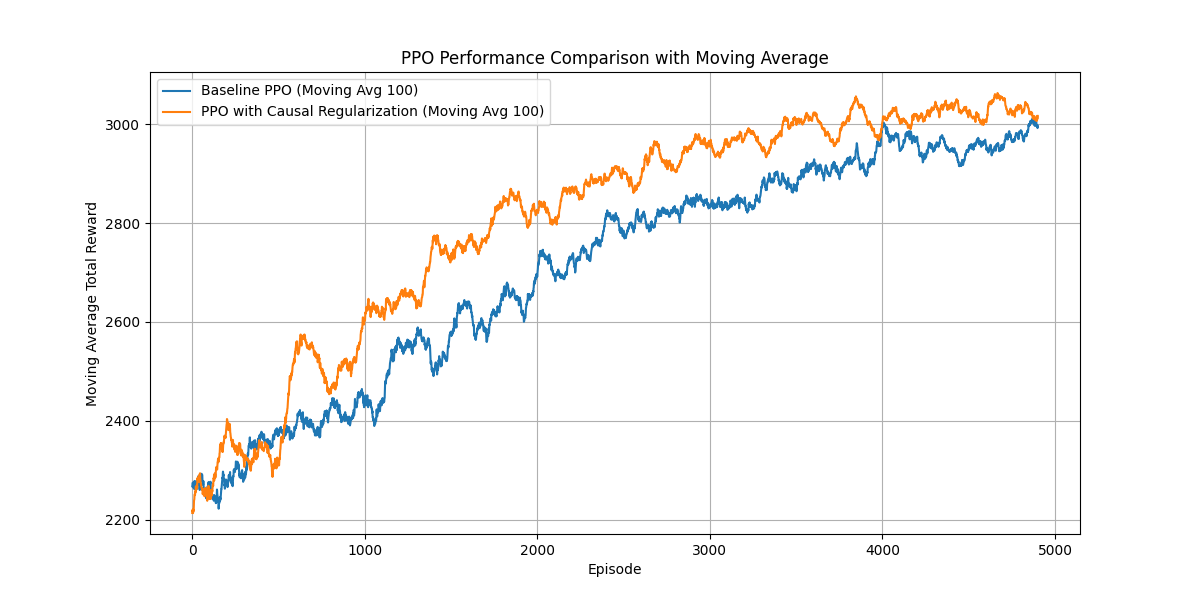